In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
data_df = pd.read_csv("../data/shakespeare/Shakespeare_data.csv")

data_df[data_df["PlayerLine"].str.contains(':')]
data_df.drop(data_df[data_df["PlayerLinenumber"].isna()].index, inplace=True)
data_df.drop(data_df[data_df["ActSceneLine"].isna()].index, inplace=True)
data_df.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"
5,6,Henry IV,1.0,1.1.3,KING HENRY IV,And breathe short-winded accents of new broils
6,7,Henry IV,1.0,1.1.4,KING HENRY IV,To be commenced in strands afar remote.
7,8,Henry IV,1.0,1.1.5,KING HENRY IV,No more the thirsty entrance of this soil


In [18]:
data = ' '.join(data_df['PlayerLine'].astype(str))
data = data[:1000]
# data

In [19]:
def preprocess(data):
    data = data.replace('“', ' " ')
    data = data.replace('”', ' " ')
    data = data.replace('\n',' ')
    data = data.replace('\t',' ')

    for c in ['!','$',"'",'(',')',',','-','.',':','?','[',']']:
        data = data.replace(c, ' {0} '.format(c))

    corpus = data.lower().split(' ')
    corpus = [word for word in corpus if word != '']
    unique_words = list(set(corpus))
    
    return corpus, unique_words

def word_cloud(tokens):
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    import nltk

    frequency_dist = nltk.FreqDist(tokens)
    fig=plt.figure(figsize=(8,5), dpi= 100, facecolor='w', edgecolor='k')
    frequency_dist.plot(30,cumulative=False)
    wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
    fig=plt.figure(figsize=(10,8), dpi= 100, facecolor='w', edgecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [20]:
def getDictForm(np_arr):
#     print(np_arr)
    dict_form = {}
    for i in range(np_arr.shape[0]):
        temp = {}
        for j in range(np_arr[i].shape[0]):
            temp[j] = np_arr[i,j]
        dict_form[i] = temp
    return dict_form

print(getDictForm(np.random.randint(10, size=(1,5))))

{0: {0: 5, 1: 8, 2: 6, 3: 7, 4: 0}}


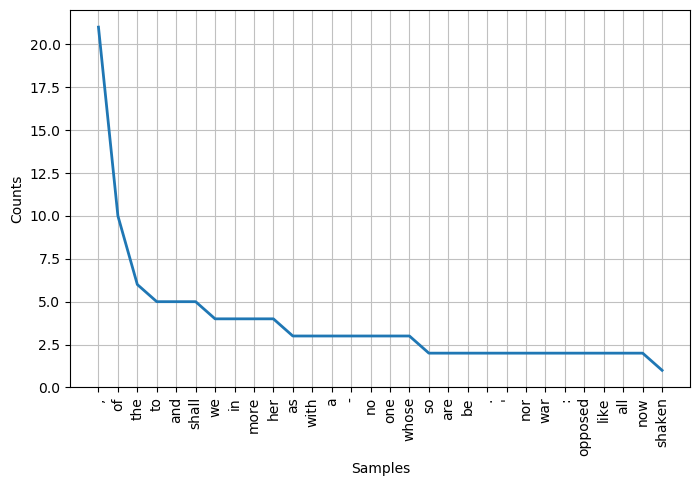

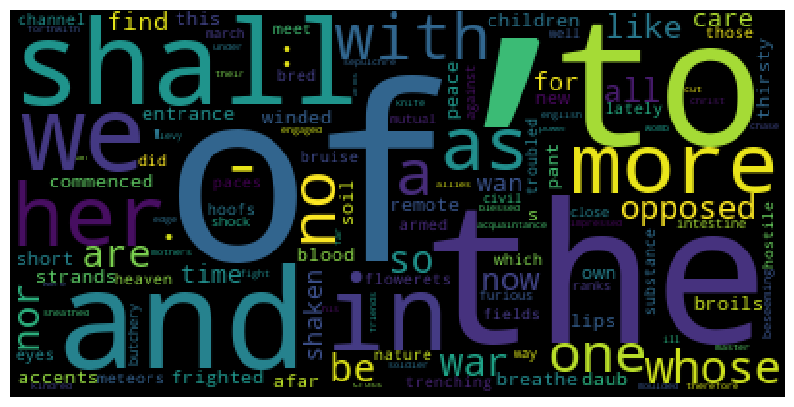

In [21]:
# fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

corpus, unique_words = preprocess(data)
word_cloud(corpus)

from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
encodings = encoder.fit(unique_words)
encoded_corpus = encoder.transform(corpus)
unique_encoded_corpus = sorted(list(set(encoded_corpus)))
# print(encoded_corpus)


In [22]:
# Initial Probabilities
len_corpus = encoded_corpus.shape[0]
no_states = len(unique_encoded_corpus)
# print(no_states)
init_pi    = []                   # Initial Probability
A = np.zeros((no_states, no_states))  # Transition Probabiltiy Matrix
B = np.zeros_like(A)                  # Observation Likelihood / Emission Probability

# Calculating Initial Probability
for cor in unique_encoded_corpus:
    init_pi.append(np.sum(encoded_corpus == cor)/len_corpus)

# Calculating Transition Probabiltiy Matrix
for i in range(no_states):
    src_states = np.where(encoded_corpus == i)[0]
    for src in src_states:
        if (src+1) < no_states:
            dst = encoded_corpus[src+1]
            A[src, dst] += 1/src_states.shape[0]

# Laplace Smoothing
A[A!=0]= A[A!=0] + (1/no_states)
A[A==0]=1/no_states

B = A.transpose()

<div align="center"> <h2><b>Forward Algorithm (Alpha) </div>
<div style="text-align:center"><img src="../images/frwd.png" /></div>

In [23]:
def gaussian_density_1D(X, mean, sigma):
    return (1/(np.power(2*np.pi, 0.5) * sigma)) * np.exp(-np.power(X-mean, 2) / (2 * sigma**2))

# x = np.random.rand(1,3)
# mu = np.random.rand(1)
# print(x, mu)
# sigma = 1
# print(gaussian_density_1D(x, mu, sigma))

def forward(observation, init_pi, A, B):
    forwardMat = np.ones_like(A)
    no_states = A.shape[0]
    norm_c = np.zeros(no_states)
    T = len(observation)
    
    # Initialization
    for s in range(no_states):
        forwardMat[s,0] = init_pi[s] * B[0, s]
    
    norm_c[0] = np.sum(forwardMat[:,0])
    forwardMat[:,0] = forwardMat[:,0]/norm_c[0]
    
    # Recursion    
    for t in range(1, T):
        for s in range(no_states):
            forwardMat[s, t] = np.sum(np.multiply(forwardMat[:,t-1], A[:, s])) * B[t, s]
        norm_c[t] = np.sum(forwardMat[:,t])
        forwardMat[:,t] = forwardMat[:,t]/norm_c[t]
        
    # Termination
    forwardProb = np.sum(forwardMat[:, T-1])
    return forwardMat, forwardProb, norm_c

forwardMat, forwardProb, norm_c = forward(unique_encoded_corpus, init_pi, A, B)

# MU = np.random.rand(1,3)
# SIGMA = [np.eye(1) for i in range(3)]
# print(SIGMA)
# print(normPDF(encoded_corpus.reshape(-1,1), np.random.rand(1,1), np.eye(1)))
# # print(encoded_corpus.reshape(-1,1).shape)

<div align="center"> <h2><b>Backward Algorithm (Beta) </div>
<div style="text-align:center"><img src="../images/bkwd.png" /></div>

In [24]:
def backward(observation, init_pi, A, B, norm_c):
    backwardMat = np.ones_like(A)
    no_states = A.shape[0]
    T = len(observation)
    
    # Initialization
    backwardMat[:, T-1] = 1
    
    # Recursion
    for t in range(T-2, -1, -1):
        for s in range(no_states):
            backwardMat[s, t] = np.sum(A[s, :] * B[t+1, :] * backwardMat[:,t+1])
        backwardMat[:,t] /= norm_c[t+1]
    
    # Termination
    backwardProb = np.sum(init_pi * B[0, :] * backwardMat[:, 0])
    return backwardMat, backwardProb
    
backwardMat, backwardProb = backward(unique_encoded_corpus, init_pi, A, B, norm_c)

<div align="center"> <h2><b> Expectation Maximization of HMM </div>
<div style="text-align:center"><img src="../images/em.png" /></div>


In [25]:
def expectation_step(observation, init_pi, A, B):
    forwardMat, forwardProb, norm_c = forward(observation, init_pi, A, B)
    backwardMat, backwardProb = backward(observation, init_pi, A, B, norm_c)
    
    # Calculate Gamma_t(j)
    gamma = forwardMat * backwardMat

    no_states = A.shape[0]
    T = len(observation)
    
    psi = np.zeros((no_states,no_states,T))
    
    # Calculate psi_t(i,j)
    for t in range(1, T):
        psi[:, :, t] = (forwardMat[:,t-1][None].T.dot(backwardMat[:, t][None])*A) / norm_c[t]
        for j in range(no_states):
            psi[:, j, t] *= B[t, :]

    return gamma, psi, norm_c

def maximization_step(observation, psi, gamma):
    psi_sum_t = np.sum(psi,axis=2)
    
    # Calculating updated Transition Probability
    A_est = psi_sum_t/np.sum(psi_sum_t,axis=1)
    
    no_states = gamma.shape[0]
    T = len(observation)
    B_est = np.zeros((T,no_states))
    
    init_pi = gamma[:,0]/np.sum(gamma[:,0])
    
    # Calculating updated Emission Probability
    for j in range(no_states):
        for obs in range(T):
            B_est[observation[obs], j] = np.sum(gamma[j,:])/np.sum(gamma, axis=1)[j]
    
    return (init_pi, A_est, B_est)

gamma, psi, norm_c = expectation_step(unique_encoded_corpus, init_pi, A, B)
maximization_step(unique_encoded_corpus, psi, gamma)


(array([0.00478123, 0.05261325, 0.00709548, 0.00473139, 0.00482591,
        0.00697435, 0.00240774, 0.02684133, 0.00236581, 0.0025087 ,
        0.00465236, 0.00246106, 0.00235309, 0.01183795, 0.00502169,
        0.00249516, 0.00246226, 0.00748672, 0.00470487, 0.0025087 ,
        0.00232454, 0.00235265, 0.00246402, 0.00247032, 0.00238026,
        0.00261536, 0.00274247, 0.00233372, 0.00247561, 0.00249557,
        0.00234737, 0.00240694, 0.00249627, 0.00235308, 0.00247056,
        0.02684133, 0.00247193, 0.00240524, 0.00237588, 0.00236243,
        0.00234198, 0.00249333, 0.00274247, 0.0023348 , 0.0084155 ,
        0.00247514, 0.00235012, 0.00249574, 0.00236431, 0.02684133,
        0.00237672, 0.00235857, 0.0024662 , 0.31453028, 0.00238884,
        0.00987231, 0.0025087 , 0.00232479, 0.00240521, 0.00235669,
        0.00235243, 0.0098769 , 0.00240787, 0.00249574, 0.00236248,
        0.0025087 , 0.00232479, 0.00481806, 0.00249574, 0.00235573,
        0.02684133, 0.0023775 , 0.00234855, 0.00

<div align="center"> <h2><b> Veterbi Algorithm </div>
<div style="text-align:center"><img src="../images/veterbi.png" /></div>


In [31]:
def viterbi(observation, init_pi, A, B):
    v = np.ones_like(A)
    bt = np.ones_like(A)
    
    no_states = A.shape[0]
    T = len(observation)
    
    for s in range(no_states):
        v[s,0] = init_pi[s] * B[0, s]
        bt[s,0] = 0
    
    for t in range(1, T):
        for s in range(no_states):
            v[s, t] = np.amax(np.multiply(v[:,t-1], A[:, s]) * B[t, s], axis=0)
            bt[s, t] = np.argmax(np.multiply(v[:,t-1], A[:, s]) * B[t, s], axis=0) * B[t, s]
    
    p_star = np.amax(v[:, T-1])
    q_star = np.argmax(v[:, T-1])

    path = [q_star]
    previous = q_star
    
    for t in range(v.shape[1] - 2, -1, -1):
        previous = np.argmax(v[:, t])
        path.insert(0, previous)
        
    return p_star, q_star, np.array(path)

# print(viterbi(unique_encoded_corpus, init_pi, A, B))

Iteration:  0  Likelihood:  -502.9574764594402
Iteration:  1  Likelihood:  0.27932388861128127
Iteration:  2  Likelihood:  1.231350835393327
Iteration:  3  Likelihood:  1.936150321577256
Iteration:  4  Likelihood:  2.140175298358166
Iteration:  5  Likelihood:  2.1765531211868065
Iteration:  6  Likelihood:  2.179872348659986
Iteration:  7  Likelihood:  2.1753758771410703
Iteration:  8  Likelihood:  2.168214011129263
Iteration:  9  Likelihood:  2.159874330767592


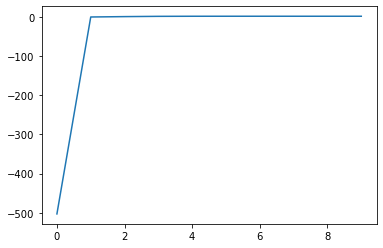

Enter a seen sequence of words :  no more


[79 73]
The best prediction is 'furious beseeming ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' beseeming'
None


In [32]:
def train(observation, init_pi, A, B, encoder):
    log_likelihood_hist = []
    for i in range(10):
        gamma, psi, norm_c = expectation_step(observation, init_pi, A, B)
        (init_pi, A, B) = maximization_step(observation, psi, gamma)
        log_likelihood = np.sum(np.log(norm_c))
        print("Iteration: ", i, " Likelihood: ", log_likelihood)
        log_likelihood_hist.append(log_likelihood)
    plt.plot(log_likelihood_hist)
    plt.show()

def predict(encoder):
    sequence = input('Enter a seen sequence of words : ')
    corpus, _ = preprocess(sequence)
    try:
        observation = encoder.transform(corpus)
        print(observation)
    except ValueError:
        print("[X] Unseen Sequence Entered")
        
    p_star, q_star, path = viterbi(observation, init_pi, A, B)
    words = encoder.inverse_transform(path.astype(int))
    print("The best prediction is '{0}'".format(' '.join(words)))
    

def generate():
    pass

train(unique_encoded_corpus, init_pi, A, B, encoder)
print(predict(encoder))
